### Referanser for hjelp til kode og bygging av modell:
https://www.projectpro.io/article/how-to-build-arima-model-in-python/544
https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide
https://medium.com/p/bb83e49210cd



# Implementasjon av AUTO-ARIMA for Spiller1

#### Import av nødvendige bibliotek

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import figure
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

## Steg 1: Importere datasettet
#### Bruker datasettet til én av de fire spillerne vi har valgt ut:

In [2]:
data = pd.read_csv('../../Spiller1.csv')
data

,Date,Fatigue,Mood,Readiness,Sleep Durhation,Sleep Quality,Soreness,Stress
0,2020-03-20,3.0,3.0,7.0,9.0,3.0,3.0,2.0
1,2020-03-21,3.0,3.0,6.0,8.0,3.0,2.0,3.0
2,2020-03-22,3.0,3.0,6.0,9.0,3.0,3.0,4.0
3,2020-03-23,3.0,3.0,7.0,9.0,4.0,3.0,3.0
4,2020-03-24,3.0,3.0,6.0,9.0,3.0,2.0,3.0
...,...,...,...,...,...,...,...,...
647,2021-12-27,2.0,3.0,3.0,8.0,2.0,2.0,3.0
648,2021-12-28,2.0,3.0,4.0,570.0,4.0,3.0,3.0
649,2021-12-29,3.0,3.0,5.0,8.0,3.0,3.0,3.0
650,2021-12-30,3.0,3.0,5.0,9.0,3.0,3.0,3.0


## Steg 2: Etter at dataen er importert, må den prepareres
#### Her velger vi ut Readiness-parameteren som skal brukes til å gjøre prediksjoner med, og tar med oss datoene til å opprette et nytt datasett med disse utvalgte kolonnene.
#### Deretter vil vi konvertere 'Date'-kolonnen til datetime, og setter videre dette som index. Frekvensen blir satt til 'D' (daglig).

In [3]:
data = data[['Date', 'Readiness']]

In [4]:
# Preparering av dataen

data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data.set_index('Date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('D')
data = data.sort_index()
data.head()

<ipython-input-4-65bae8d37088>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)


,Readiness
Date,
2020-03-20,7.0
2020-03-21,6.0
2020-03-22,6.0
2020-03-23,7.0
2020-03-24,6.0


# Steg 3: Størrelse på datasett
#### Datsettet avgrensens til å være fra 21.03.2020 til 31.12.2021. Gjøres likt hos alle fire spillere sine datasett.

In [5]:
data = (data.loc['2020-03-21':'2021-12-31'])

# Steg 4: Manglende verdier
#### Datasettet inneholder manglende verdier, og disse tomme verdiene blir fylt med en metode kalt 'ffill'. Det vil si at kolonnen med manglende verdi blir fylt inn med verdien fra foregående dag.

In [6]:
data['Readiness'] = data['Readiness'].fillna(method='ffill')

#### Plotter datasettet for å visualisere det, og se at det ikke er noen hull som følge av manglende verdier. Vil videre analysere og forstå hvordan det utspiller seg. 

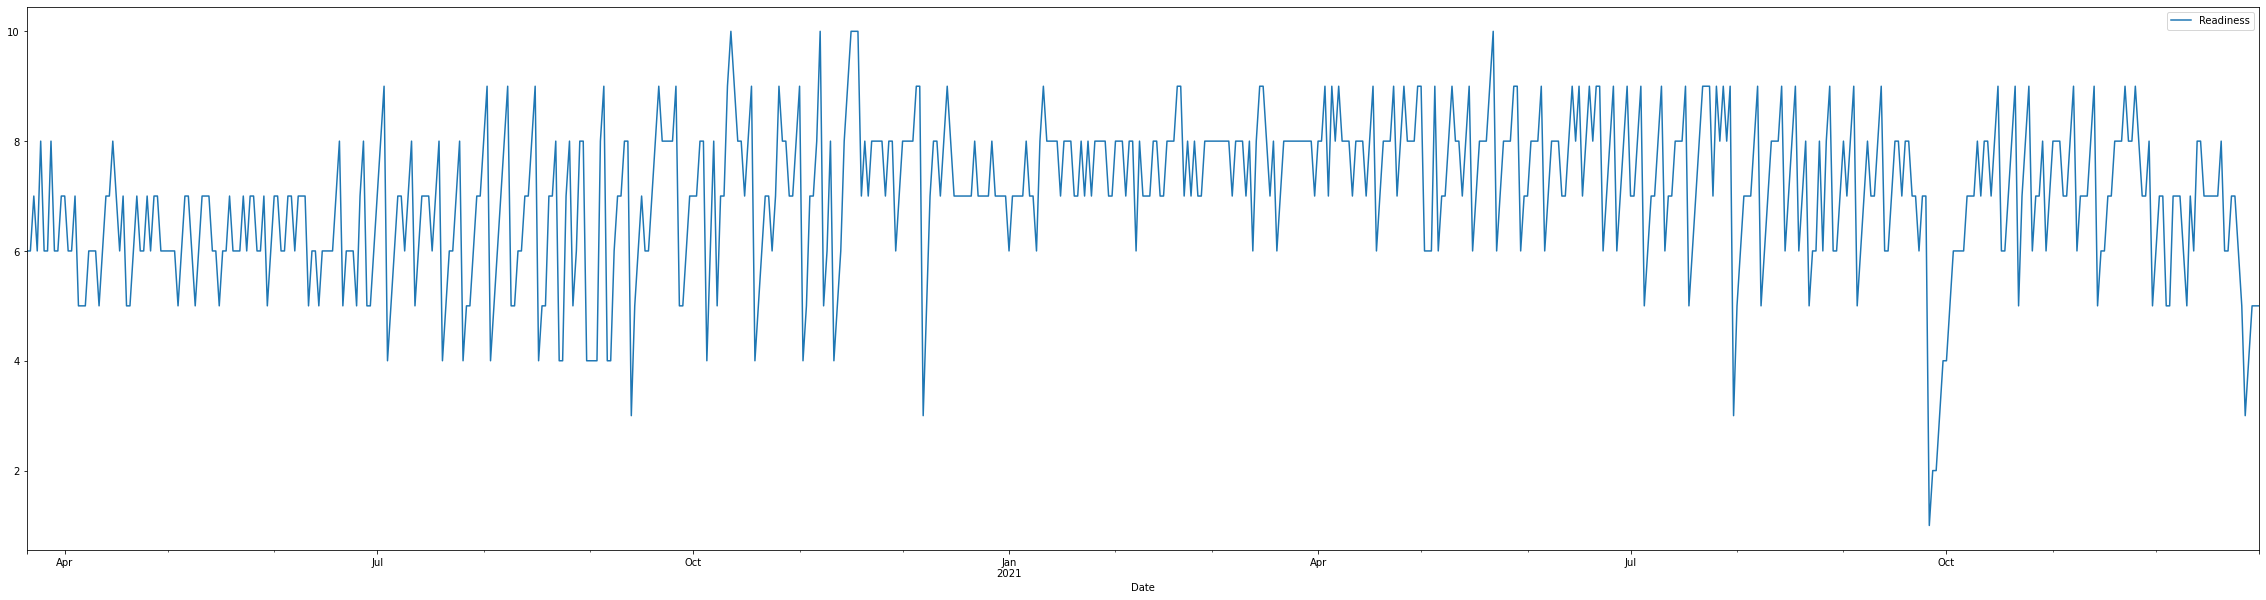

In [7]:
dataPlot = data.plot(figsize=(40, 10))

# Steg 5: Sjekke om dataen er stasjonær
#### Tar i bruk ADF-test for å sjekke om dataen er stasjonær. 

ADF-test for Spiller1:
ADF Statistikk: -2.6068564377200225
p-verdi: 0.09158844531264693
Kritiske verdier:
	1%: -3.4407724517110783
	5%: -2.866138605582151
	10%: -2.569218982111363


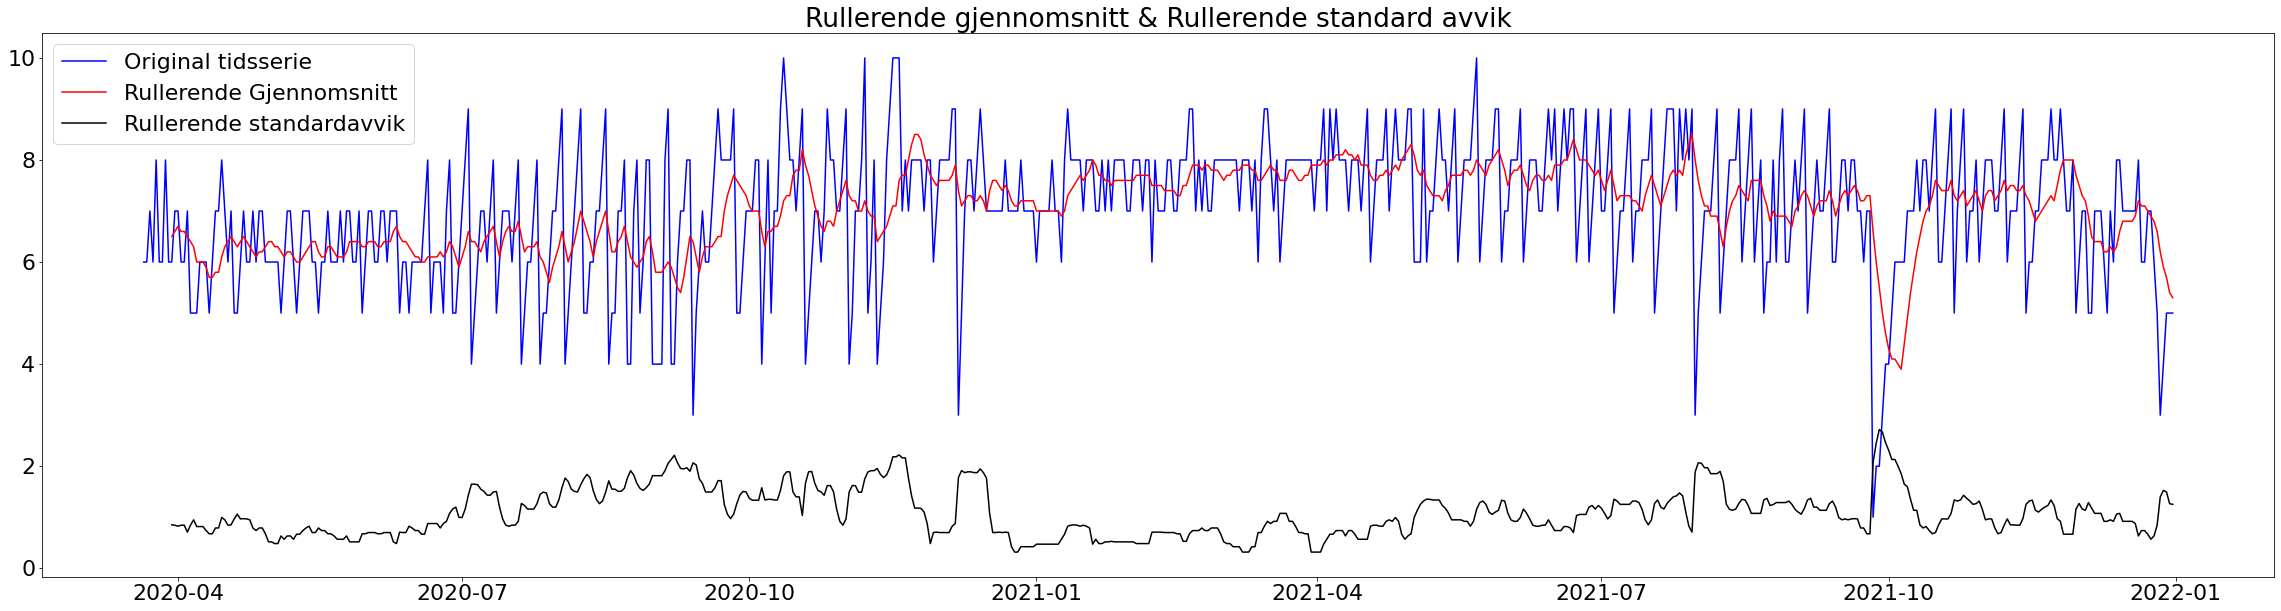

In [8]:
def stasjonaritet_sjekk(tidsserie):
    
    # Rolling Statistics
    rolling_mean = data.rolling(window = 10).mean()
    rolling_std = data.rolling(window = 10).std()

    plt.plot(data, color = 'blue', label = 'Original tidsserie')
    plt.plot(rolling_mean, color='red', label='Rullerende Gjennomsnitt')
    plt.plot(rolling_std, color = 'black', label = 'Rullerende standardavvik')
    plt.legend(loc = 'best')
    plt.title('Rullerende gjennomsnitt & Rullerende standard avvik')
    
    
    # Dickey-Fuller test:
    result = adfuller(data['Readiness'])
    
    print('ADF-test for Spiller1:')
    print('ADF Statistikk: {}'.format(result[0]))
    print('p-verdi: {}'.format(result[1]))
    print('Kritiske verdier:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
        
plt.rcParams["figure.figsize"] = (40,10)
plt.rcParams.update({'font.size': 22})
stasjonaritet_sjekk(data)

#### Optimal p-verdi skal helst være under 0.05 for å kunne si at tidsserien er stasjonær. Basert på en helhetlig vurdering av hvordan tidsserien fremstår, sammen med en relativt lav p-verdi, konkluderer vi med at tidsserien er nærmest stasjonær. I denne testen vil likevel Auto-ARIMA avgjøre om det er hensiktsmessig å differensiere tidsserien.

# Steg 6: Bygger Auto-ARIMA modell

### Basert på bestemte utgangspunkt blir lag-verid avgrenset til 3.

In [9]:
stepwise_model = auto_arima(data, start_p=3, start_q=3, max_p=3,
                           max_q =5, m=7,
                           start_P=1, seasonal=True,
                           d=None, D=None, trace=True, error_action ='ignore',
                           suppress_warnings=True, stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(1,0,1)[7] intercept   : AIC=2063.944, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2315.459, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2264.945, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2130.318, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2313.460, Time=0.01 sec
 ARIMA(3,1,3)(0,0,1)[7] intercept   : AIC=2062.539, Time=1.46 sec
 ARIMA(3,1,3)(0,0,0)[7] intercept   : AIC=2052.646, Time=0.84 sec
 ARIMA(3,1,3)(1,0,0)[7] intercept   : AIC=2059.468, Time=1.41 sec
 ARIMA(2,1,3)(0,0,0)[7] intercept   : AIC=2067.488, Time=0.67 sec


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,2)(0,0,0)[7] intercept   : AIC=2069.751, Time=0.65 sec
 ARIMA(3,1,4)(0,0,0)[7] intercept   : AIC=2069.374, Time=0.87 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=2068.511, Time=0.33 sec
 ARIMA(2,1,4)(0,0,0)[7] intercept   : AIC=2063.192, Time=0.85 sec
 ARIMA(3,1,3)(0,0,0)[7]             : AIC=2047.726, Time=0.73 sec
 ARIMA(3,1,3)(1,0,0)[7]             : AIC=2050.849, Time=1.07 sec
 ARIMA(3,1,3)(0,0,1)[7]             : AIC=2051.819, Time=1.51 sec
 ARIMA(3,1,3)(1,0,1)[7]             : AIC=2036.551, Time=2.77 sec
 ARIMA(3,1,3)(2,0,1)[7]             : AIC=2024.030, Time=10.47 sec
 ARIMA(3,1,3)(2,0,0)[7]             : AIC=2044.926, Time=11.26 sec
 ARIMA(3,1,3)(2,0,2)[7]             : AIC=2028.322, Time=10.92 sec
 ARIMA(3,1,3)(1,0,2)[7]             : AIC=2026.648, Time=5.61 sec
 ARIMA(2,1,3)(2,0,1)[7]             : AIC=2025.172, Time=3.45 sec
 ARIMA(3,1,2)(2,0,1)[7]             : AIC=2026.717, Time=6.08 sec
 ARIMA(3,1,4)(2,0,1)[7]             : AIC=2026.607, Time=5.37 sec
 ARIMA(

# Steg 6: Deler inn i trening- og testsett
### Fordelingen er følgende: Datasettene består av totalt 651 verdier, hvor 80% av disse skal brukes til trening og 20% skal brukes til test og prediksjon. Dette gir oss følgende:
#### Treningssett: 520 verdier
#### Testsett: 131 verdier

In [10]:
train = data[:520]
test = data[520:]

In [11]:
stepwise_model.fit(train)

ARIMA(order=(3, 1, 3), scoring_args={}, seasonal_order=(2, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [12]:
future_forecast = stepwise_model.predict(n_periods=131)

<AxesSubplot:xlabel='Date'>

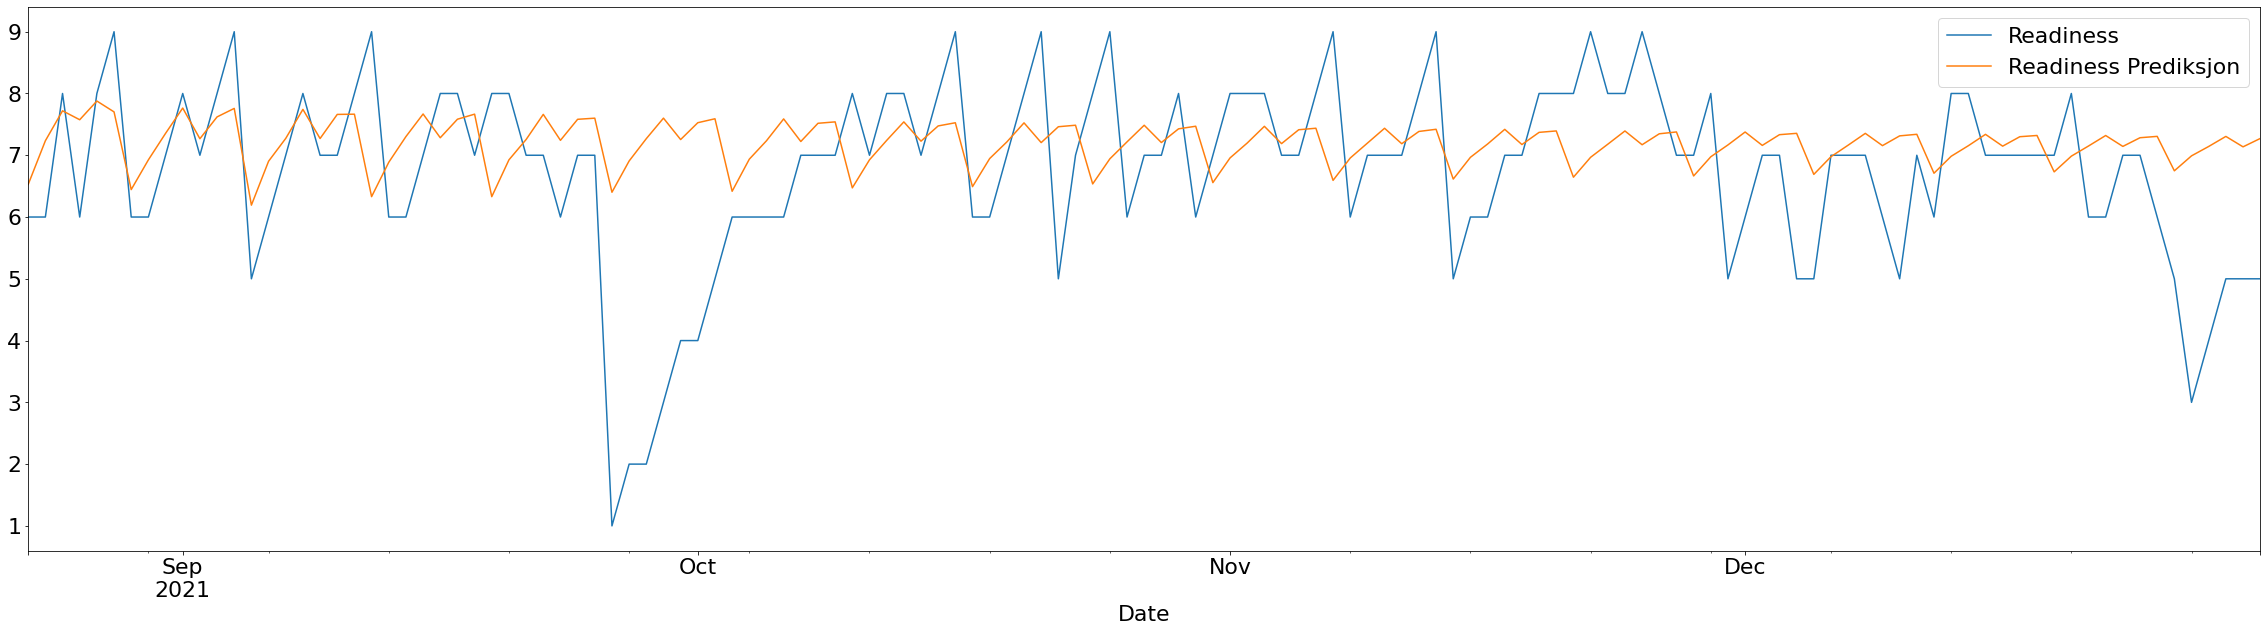

In [13]:
future_forecast = pd.DataFrame(future_forecast, index =
                              test.index, columns=['Readiness Prediksjon'])
pd.concat([test, future_forecast], axis=1).plot()

In [14]:
future_forecast.head(7)

,Readiness Prediksjon
Date,
2021-08-23,6.527644
2021-08-24,7.234588
2021-08-25,7.719769
2021-08-26,7.574973
2021-08-27,7.877821
2021-08-28,7.701758
2021-08-29,6.444121


In [15]:
test.head(7)

,Readiness
Date,
2021-08-23,6.0
2021-08-24,6.0
2021-08-25,8.0
2021-08-26,6.0
2021-08-27,8.0
2021-08-28,9.0
2021-08-29,6.0


<AxesSubplot:xlabel='Date'>

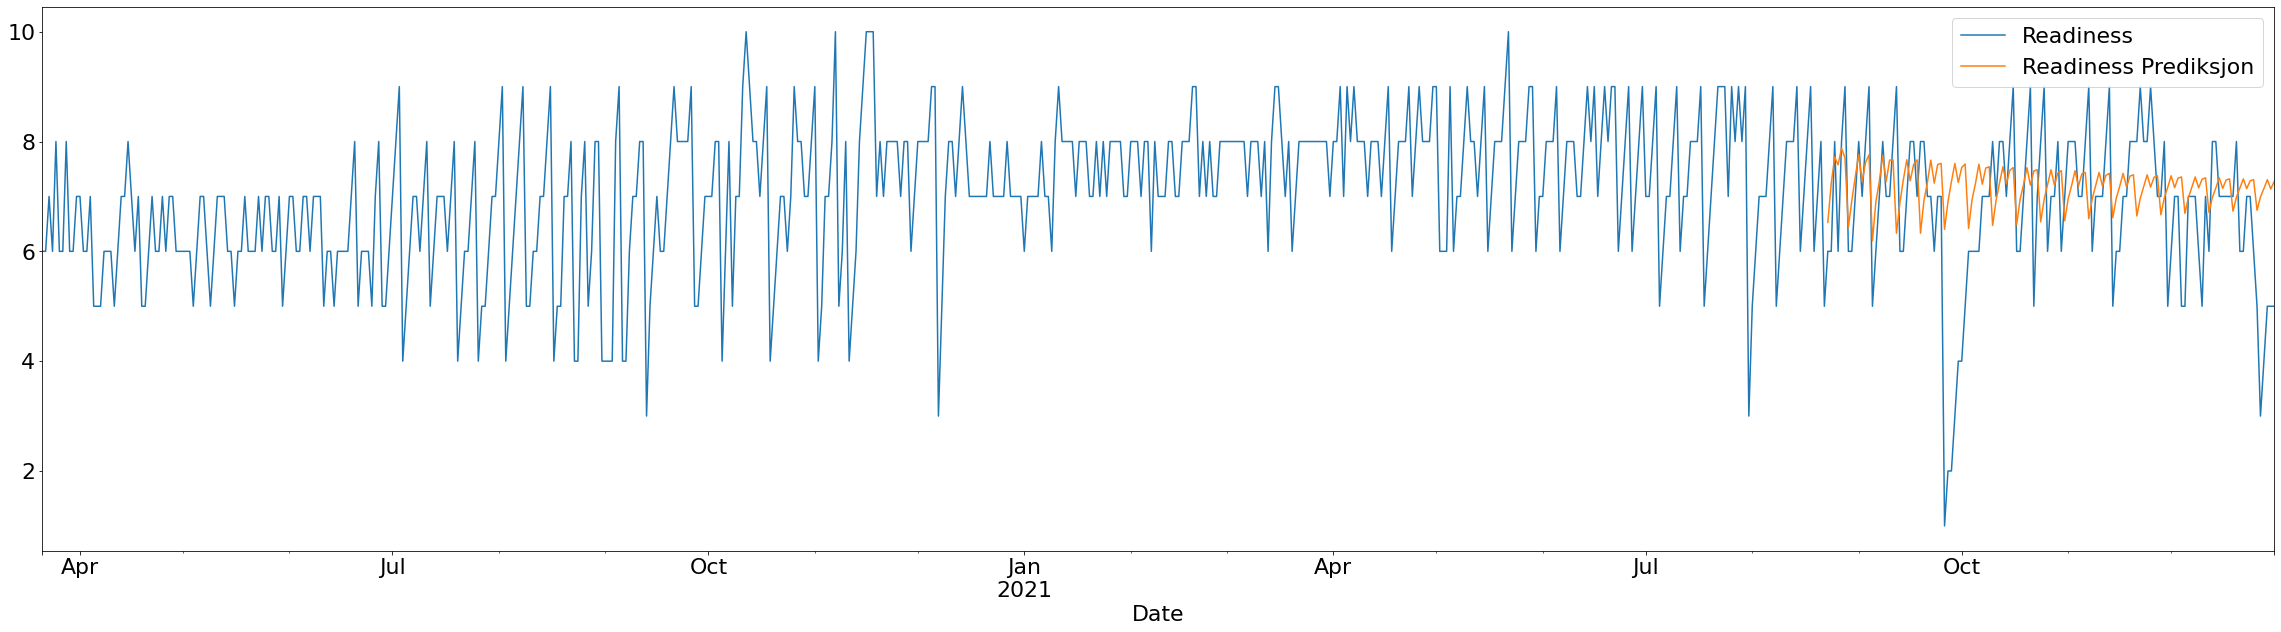

In [16]:
readiness_forecast = pd.concat([data, future_forecast],axis=1)
readiness_forecast.plot(figsize=(40,10))

<AxesSubplot:xlabel='Date'>

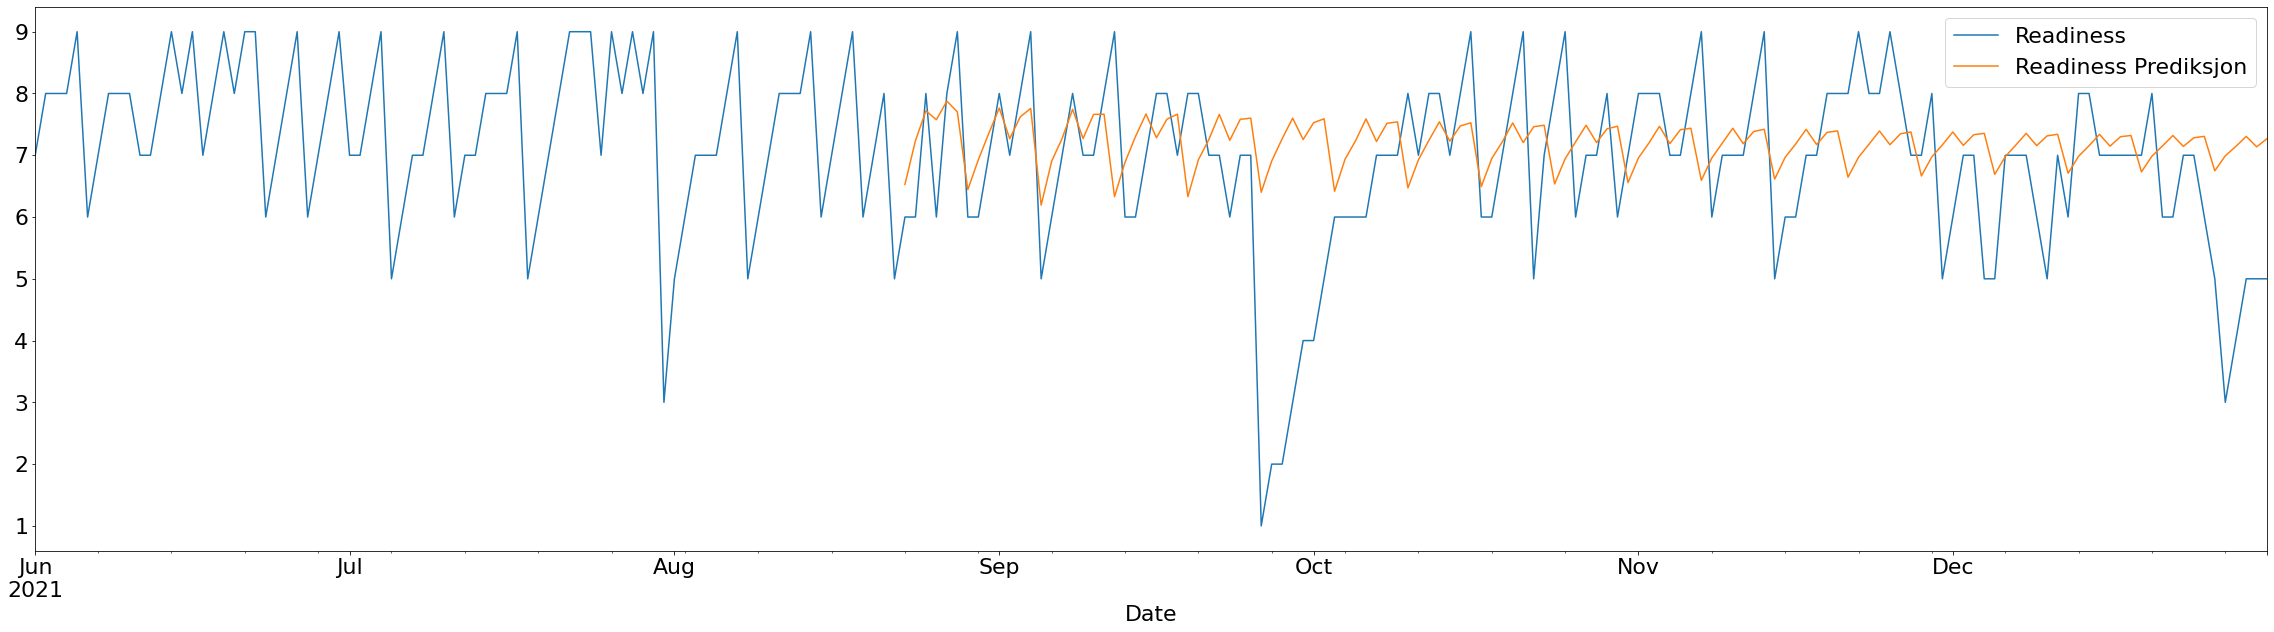

In [17]:
readiness_forecast = readiness_forecast.loc['2021-06-01':]
readiness_forecast.plot(figsize=(40,10))

In [18]:
print('---- Oversikt over testscore for Spiller1: ----')
# print('Test error for tidsperiode: ', testperiode, ' hvor treningsperioden er ', treningsperiode)
print('')

# Skriver ut MAE 
print('MAE:', metrics.mean_absolute_error(test, future_forecast))

# Skriver ut MSE
print('MSE:', metrics.mean_squared_error(test, future_forecast))

print('R^2:', metrics.r2_score(test, future_forecast))

---- Oversikt over testscore for Spiller1: ----

MAE: 1.089798634479958
MSE: 2.2888130719938133
R^2: -0.057005412499618435
